In [1]:
import tensorflow as tf
from keras import backend as K
import os
import pandas as pd
import cv2 as cv
import numpy as np
import sys
sys.path.insert(0, "../")
from deeparuco.impl.utils import IoU, match_rois
from tensorflow.keras.models import load_model
from ultralytics import YOLO
import matplotlib.pyplot as plt
import csv
import time
import json
from shapely.geometry import Polygon

def calculate_iou(boxA, boxB):    
    polyA = Polygon(boxA)
    polyB = Polygon(boxB)
    
    if not polyA.is_valid or not polyB.is_valid:
        return 0.0
    
    intersection_area = polyA.intersection(polyB).area
    union_area = polyA.union(polyB).area
    
    return intersection_area / union_area if union_area > 0 else 0.0

2024-11-04 13:27:23.431864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 13:27:23.543987: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 13:27:23.577819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 13:27:23.803104: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-04 13:27:25.312469: W tensorflow/compiler/tf2

WARNING ⚠️ Python>=3.10 is required, but Python==3.9.5 is currently installed 


In [2]:
model = YOLO('../models/nested2_detector_m/weights/best.pt')

One image

0: 416x640 2 markers, 27.0ms
Speed: 13.1ms preprocess, 27.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)
0.01639638057739618
0.9695295102776704
0.24818139556610022
0.9983991130728543
0.016140966177359814
0.004066092482925436


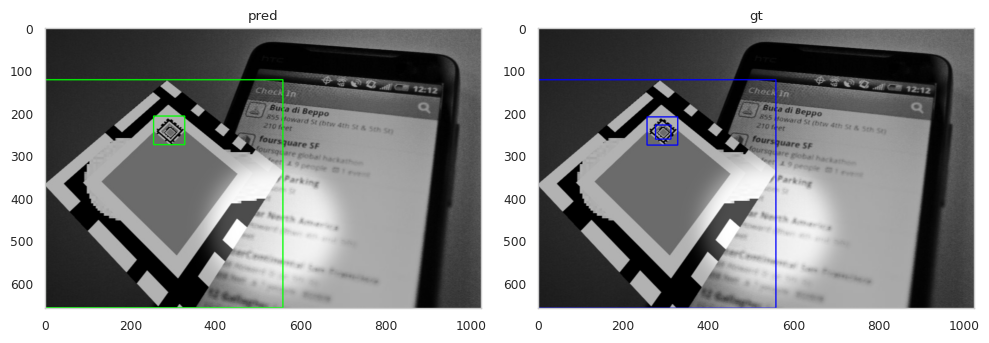

In [19]:
im_path    = '../dataset/nested2/images/test/a29559e95000e3a3.jpg'
label_path = '../dataset/nested2/labels/test/a29559e95000e3a3.json'

with open(label_path, 'r') as l:
    data = json.load(l)

im = cv.imread(im_path)
im_gt = cv.imread(im_path)
h, w = im.shape[:2]

results = model(im)[0]
for result in results.boxes.data.tolist():
    x1, y1, x2, y2, score, class_id = result
    for marker in data:
        pred_bbox = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
        bbox = marker['bbox_corners']
        bbox = [(max(0, min(x, w)), max(0, min(y, h))) for x, y in bbox]
        iou = calculate_iou(pred_bbox, bbox)
        print(iou)
    cv.rectangle(im, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

# To display the image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(im)
plt.grid(False)
plt.title('pred')

plt.subplot(1, 2, 2)
for marker in data:
    bbox = marker['bbox_corners']
    bbox = [(int(max(0, min(x, w))), int(max(0, min(y, h)))) for x, y in bbox]
    cv.rectangle(im_gt, bbox[0], bbox[2], (0, 0, 255), 2)
plt.imshow(im_gt)
plt.title('gt')
plt.grid(False)
plt.tight_layout()
plt.show()

In [4]:
def is_bbox_in_bounds(bbox_corners, h, w):
    marker_w = bbox_corners[2][0]-bbox_corners[0][0]
    marker_h = bbox_corners[2][1]-bbox_corners[0][1]
    for x, y in bbox_corners:
        if not (-marker_w/14 <= x <= w+marker_w/14 and -marker_h/14 <= y <= h+marker_h/14):
            return False
    return True  

In [ ]:
im_path    = '../dataset/nested2/images/test/a29559e95000e3a3.jpg'
label_path = '../dataset/nested2/labels/test/a29559e95000e3a3.json'


with open(label_path, 'r') as l:
    data = json.load(l)
im = cv.imread(im_path)
h, w = im.shape[:2]
num_markers = len(data)
IDs = []
bboxes = []
reflections = []
sizes = []
for marker in data:
    IDs.append(marker['tag_id'])
    bbox_ori = marker['bbox_corners']
    marker_w = bbox_ori[2][0]-bbox_ori[0][0]
    marker_h = bbox_ori[2][1]-bbox_ori[0][1]
    if is_bbox_in_bounds(bbox_ori, h, w):
        bbox = [(int(max(0, min(x, w))), int(max(0, min(y, h)))) for x, y in bbox_ori]
        bboxes.append(bbox)
        reflections.append(marker['reflection_area'])
        sizes.append(bbox[2][0]-bbox[0][0])

# Predict bbox
results = model(im)[0]

TPs = 0
FPs = 0
FNs = 0
matched_gt = []
FP_size = []
FP_x1 = []
FP_x2 = []
FP_y1 = []
FP_y2 = []
best_match = None
for result in results.boxes.data.tolist():
    x1, y1, x2, y2, score, class_id = result
    h, w = im.shape[:2]
    
    pred_bbox = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
    best_iou = 0
    best_match = None
    for i, (gt_bbox, id, reflection, size) in enumerate(zip(bboxes, IDs, reflections, sizes)):

        iou = calculate_iou(pred_bbox, gt_bbox)
        if iou > best_iou and iou >= 0.5:
            best_iou = iou
            best_match = id

    if best_match is not None:
        TPs += 1
        matched_gt.append(best_match)
        FP_size.append('NONE')
        FP_x1.append(x1)
        FP_x2.append(x2)
        FP_y1.append(y1)
        FP_y2.append(y2)
    else:
        FPs += 1
        matched_gt.append('NONE')
        FP_size.append(x2-x1)
        FP_x1.append(x1)
        FP_x2.append(x2)
        FP_y1.append(y1)
        FP_y2.append(y2)

FNs = len(bboxes) - len(matched_gt)

for i, matched in enumerate(matched_gt):
    # False positives
    if matched == 'NONE':
        x1 = FP_x1[i]
        x2 = FP_x2[i]
        y1 = FP_y1[i]
        y2 = FP_y2[i]
        marker_name = 'NONE'
        matched_reflection = 'NONE'
        matched_size = FP_size[i]
        print([marker_name, matched, matched_reflection, matched_size, 0, 1, 0])

    # True positives
    else:
        idx = IDs.index(matched)
        marker_name = f"{matched}"
        matched_reflection = reflections[idx]
        matched_size = sizes[idx]
        print([marker_name, matched, matched_reflection, matched_size, 1, 0, 0])
        del bboxes[idx]
        del IDs[idx]
        del reflections[idx]
        del sizes[idx]
        
# False negatives
for i, (gt_bbox, id, reflection, size) in enumerate(zip(bboxes, IDs, reflections, sizes)):
    marker_name = f"{id}"
    print([marker_name, id,reflection, size, 0, 0, 1])

[[(255, 210), (255, 276), (327, 276), (327, 210)], [(275, 229), (275, 262), (311, 262), (311, 229)]]

0: 416x640 2 markers, 26.6ms
Speed: 16.6ms preprocess, 26.6ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)
['32', 32, 20.89978961753547, 72, 1, 0, 0]
['NONE', 'NONE', 'NONE', 557.4728393554688, 0, 1, 0]
['5', 5, 20.89978961753547, 36, 0, 0, 1]


Multiple images

In [5]:
eval_path = '../dataset/nested2/detect_eval_model_m.csv'
im_dir    = '../dataset/nested2/images/test/'
label_dir = "../dataset/nested2/labels/test/"
start_time = time.time()

with open(eval_path, 'a', newline='') as eval_file:
	csv_writer = csv.writer(eval_file)
	csv_writer.writerow(['image', 'id', 'reflection', 'marker_size', 'TP', 'FP', 'FN'])

	for im_name in os.listdir(im_dir):	# Read image and lable
		im_path = im_dir + im_name
		name = im_name.split('.')[0]
		label_path = label_dir + name + '.json'
		with open(label_path, 'r') as l:
			data = json.load(l)
		im = cv.imread(im_path)
		h, w = im.shape[:2]
		num_markers = len(data)
		IDs = []
		bboxes = []
		reflections = []
		sizes = []
		for marker in data:
			IDs.append(marker['tag_id'])
			bbox_ori = marker['bbox_corners']
			if is_bbox_in_bounds(bbox_ori, h, w):
				bbox = [(int(max(0, min(x, w))), int(max(0, min(y, h)))) for x, y in bbox_ori]
				bboxes.append(bbox)
				reflections.append(marker['reflection_area'])
				sizes.append(bbox[2][0]-bbox[0][0])
			
		# Predict bbox
		results = model(im)[0]

		TPs = 0
		FPs = 0
		FNs = 0
		matched_gt = []
		FP_size = []
		FP_x1 = []
		FP_x2 = []
		FP_y1 = []
		FP_y2 = []
		best_match = None
		for result in results.boxes.data.tolist():
			x1, y1, x2, y2, score, class_id = result
			h, w = im.shape[:2]
			
			pred_bbox = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
			best_iou = 0
			best_match = None

			for i, (gt_bbox, id, reflection, size) in enumerate(zip(bboxes, IDs, reflections, sizes)):
				iou = calculate_iou(pred_bbox, gt_bbox)
				if iou > best_iou and iou >= 0.5:
					best_iou = iou
					best_match = id
		
			if best_match is not None:
				TPs += 1
				matched_gt.append(best_match)
				FP_size.append('NONE')
				FP_x1.append(x1)
				FP_x2.append(x2)
				FP_y1.append(y1)
				FP_y2.append(y2)
			else:
				FPs += 1
				matched_gt.append('NONE')
				FP_size.append(x2-x1)
				FP_x1.append(x1)
				FP_x2.append(x2)
				FP_y1.append(y1)
				FP_y2.append(y2)
		
		FNs = len(bboxes) - len(matched_gt)
		
		for i, matched in enumerate(matched_gt):
			# False positives
			if matched == 'NONE':
				x1 = FP_x1[i]
				x2 = FP_x2[i]
				y1 = FP_y1[i]
				y2 = FP_y2[i]
				marker_name = name
				matched_reflection = 'NONE'
				matched_size = FP_size[i]
				csv_writer.writerow([marker_name, matched, matched_reflection, matched_size, 0, 1, 0])

			# True positives
			else:
				idx = IDs.index(matched)
				marker_name = f"{name}_{matched}"
				matched_reflection = reflections[idx]
				matched_size = sizes[idx]
				csv_writer.writerow([marker_name, matched, matched_reflection, matched_size, 1, 0, 0])
				del bboxes[idx]
				del IDs[idx]
				del reflections[idx]
				del sizes[idx]
				
		# False negatives
		for i, (gt_bbox, id, reflection, size) in enumerate(zip(bboxes, IDs, reflections, sizes)):
			marker_name = f"{name}_{id}"
			csv_writer.writerow([marker_name, id,reflection, size, 0, 0, 1])
			
				

end_time = time.time()

0: 480x640 2 markers, 104.1ms
Speed: 12.1ms preprocess, 104.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 markers, 43.6ms
Speed: 1.8ms preprocess, 43.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 2 markers, 28.9ms
Speed: 1.7ms preprocess, 28.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 2 markers, 26.3ms
Speed: 1.9ms preprocess, 26.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 2 markers, 28.2ms
Speed: 1.2ms preprocess, 28.2ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 markers, 23.2ms
Speed: 1.2ms preprocess, 23.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 markers, 22.9ms
Speed: 1.5ms preprocess, 22.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 markers, 23.3ms
Speed: 1.1ms preprocess, 23.3ms inference, 1.3ms postprocess per image at shape

In [6]:
(end_time - start_time) / 3000

0.03481547880172729

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_path_model = '../dataset/nested2/detect_eval_model_m.csv'

dfm = pd.read_csv(csv_path_model)

max_size = dfm['marker_size'].max()

bins = np.arange(0, max_size + 2, 10)
dfm['size_bin'] = pd.cut(dfm['marker_size'], bins=bins, include_lowest=True, right=False)
agg_dfm = dfm.groupby('size_bin').sum().reset_index()
agg_dfm['count'] = agg_dfm['TP'] + agg_dfm['FN']
agg_dfm = agg_dfm.loc[agg_dfm['count'] != 0].reset_index(drop=True)
agg_dfm['TP_frac'] = agg_dfm['TP'] / agg_dfm['count']
agg_dfm['FP_frac'] = agg_dfm['FP'] / agg_dfm['count']
agg_dfm['FN_frac'] = agg_dfm['FN'] / agg_dfm['count']
# agg_dfm['TP_frac'].fillna(0, inplace=True)
# agg_dfm['FP_frac'].fillna(0, inplace=True)
# agg_dfm['FN_frac'].fillna(0, inplace=True)

bin_midpoints = [(interval.left + interval.right) / 2 for interval in agg_dfm['size_bin']]

agg_dfm_TP = list(agg_dfm['TP_frac'])  
agg_dfm_FP = list(agg_dfm['FP'])
agg_dfm_FN = list(agg_dfm['FN_frac'])  

/tmp/ipykernel_12566/1586942553.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_dfm = dfm.groupby('size_bin').sum().reset_index()


In [16]:
bins_with_FN_frac_1 = agg_dfm.loc[agg_dfm['FN'] == 1, 'size_bin']
filtered_dfm = dfm[dfm['size_bin'].isin(bins_with_FN_frac_1) & (dfm['marker_size'] > 400)]
print(filtered_dfm)

                    image    id          reflection  marker_size  TP  FP  FN  \
850   b79ee19cc605140a_19    19   34.78253899549528   552.000000   1   0   0   
1536  f4c82f26340fc5ba_19    19   23.69349030729332   558.000000   1   0   0   
4244  507d5beadbfbb1b4_31    31  28.240981957857237   552.000000   0   0   1   
4385     a29559e95000e3a3  NONE                NONE   557.472839   0   1   0   
5788  fd7b8c5111f89f40_18    18    33.4855403348554   558.000000   1   0   0   
5926   8deb491ab16fe49b_8     8  50.874805598755835   556.000000   1   0   0   
7511     e91b89ea86367570  NONE                NONE   554.104324   0   1   0   
8775  f029612bd0b6e86c_21    21  50.178892204456716   555.000000   1   0   0   

            size_bin  
850   [550.0, 560.0)  
1536  [550.0, 560.0)  
4244  [550.0, 560.0)  
4385  [550.0, 560.0)  
5788  [550.0, 560.0)  
5926  [550.0, 560.0)  
7511  [550.0, 560.0)  
8775  [550.0, 560.0)  


In [13]:
bins_with_FP_frac_1 = agg_dfm.loc[agg_dfm['FP'] == 1, 'size_bin']
filtered_dfm = dfm[dfm['size_bin'].isin(bins_with_FP_frac_1) & (dfm['marker_size'] < 200) ]
print(filtered_dfm)

                                                  image  id  \
16    video-ZAtDSNuZZjkZFvMAo-frame-000126-zoY7B6uWt...  37   
22    video-4FRnNpmSmwktFJKjg-frame-000860-gSsyewyQd...  24   
31    video-6tLtjdkv5K5BuhB37-frame-000063-rohYmg56K...  34   
58    video-ePoikf5LyTTfqchga-frame-000801-as43PuANu...  45   
106   video-4FRnNpmSmwktFJKjg-frame-000844-kRxmEYtqb...  14   
...                                                 ...  ..   
8815  video-t3f7QC8hZr6zYXpEZ-frame-000379-no8Pvk4dQ...  33   
8845  video-ePoikf5LyTTfqchga-frame-000823-veuWEP5hu...  28   
8899                                7dd9e8efa288e7cd_23  23   
8925  video-SCiKdG3MqZfiE292B-frame-006417-zrMHt2yTw...  22   
8982  video-t3f7QC8hZr6zYXpEZ-frame-000284-kA5CbcnCF...   7   

               reflection  marker_size  TP  FP  FN      size_bin  
16      54.82860770207364         82.0   1   0   0  [80.0, 90.0)  
22                    0.0         88.0   1   0   0  [80.0, 90.0)  
31      2.317792068595927         88.0   1

In [14]:
total_tpm = dfm['TP'].sum()
total_fpm = dfm['FP'].sum()
total_fnm = dfm['FN'].sum()
precision_m = total_tpm / (total_tpm + total_fpm)
recall_m = total_tpm / (total_tpm + total_fnm)

print('model')
print(f'Total True Positives (TP): {total_tpm}')
print(f'Total False Positives (FP): {total_fpm}')
print(f'Total False Negatives (FN): {total_fnm}')
print(f'Total precision: {precision_m}')
print(f'Total recall: {recall_m}')

model
Total True Positives (TP): 5781
Total False Positives (FP): 154
Total False Negatives (FN): 3055
Total precision: 0.9740522325189553
Total recall: 0.6542553191489362


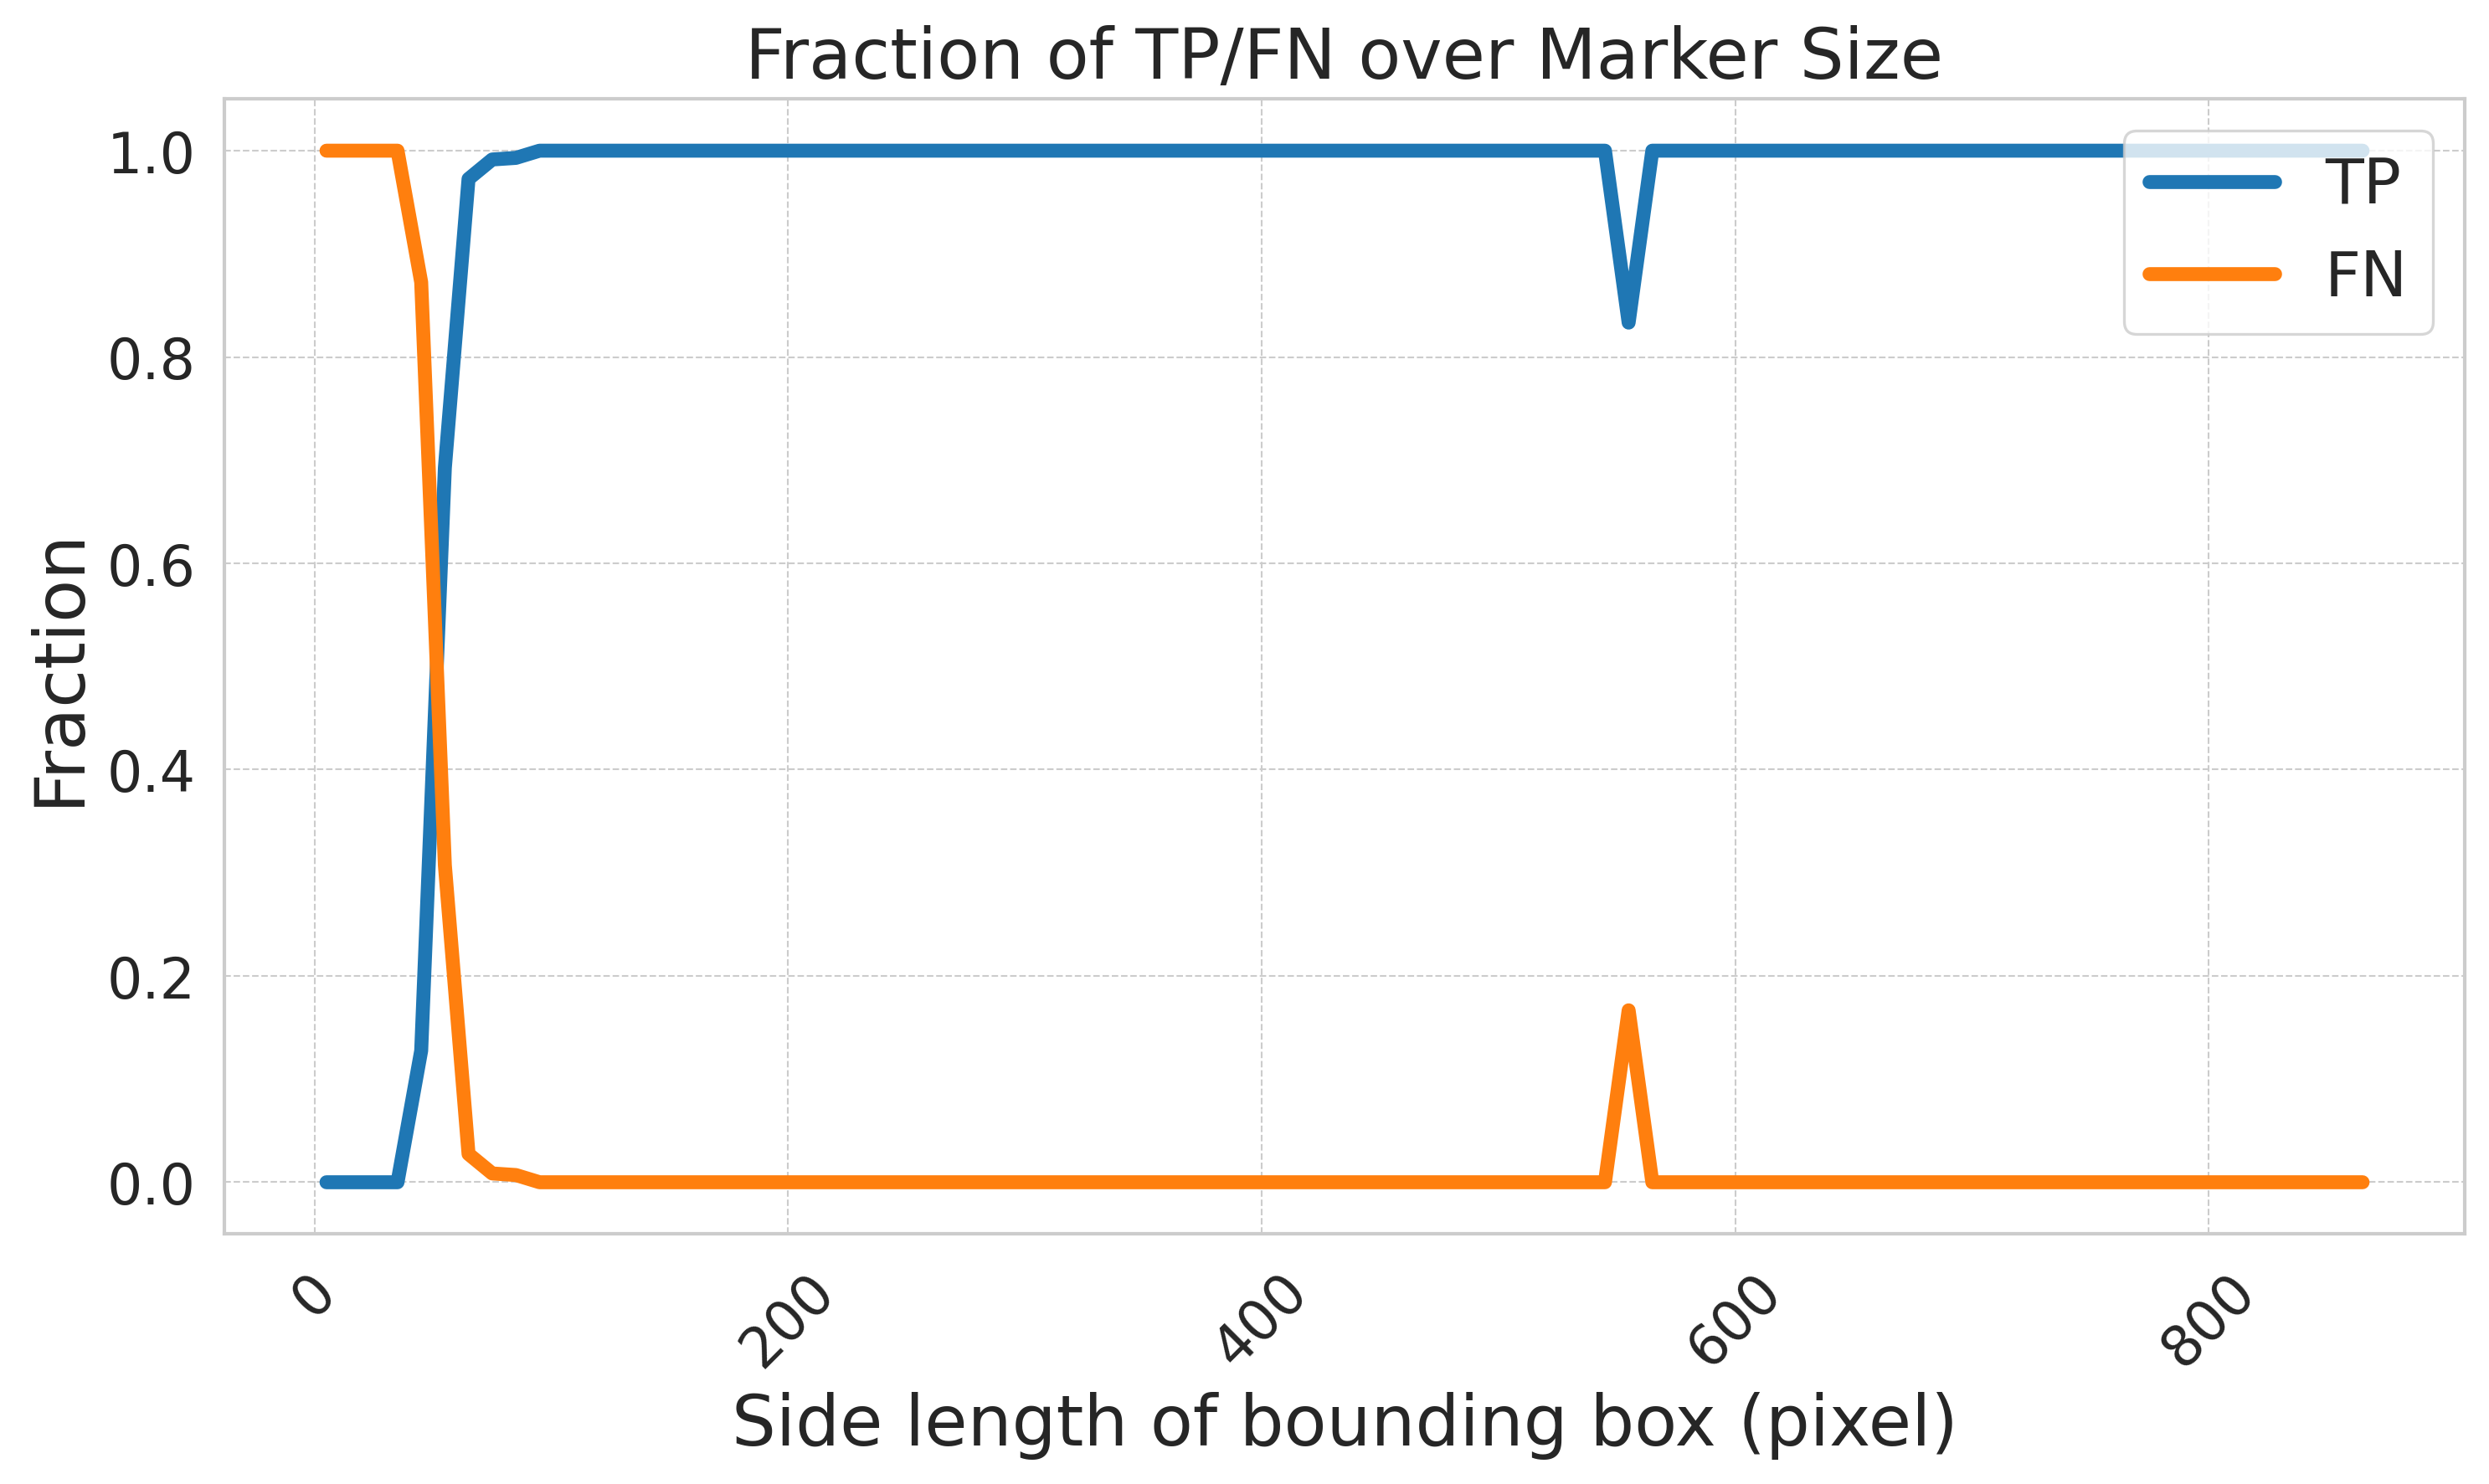

In [15]:
import seaborn as sns

sns.set_context("paper") 
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6), dpi=300)  # Higher DPI for better quality

plt.plot(bin_midpoints, agg_dfm_TP, label='TP', linestyle='-', linewidth=4, markersize=8)
# plt.plot(bin_midpoints, agg_dfm_FP, label='FP', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfm_FN, label='FN', linestyle='-', linewidth=4, markersize=8)


# Label the axes with larger font size
plt.xlabel('Side length of bounding box (pixel)', fontsize=20)
plt.ylabel('Fraction', fontsize=20)

# Add a title with a larger font size
plt.title('Fraction of TP/FN over Marker Size', fontsize=20)

# Customize the legend
plt.legend(fontsize=18, loc='upper right', frameon=True)

# Increase the tick size and rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Remove unnecessary grid lines (optional)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a high-resolution image if needed for publication
plt.tight_layout()  # This ensures everything fits well into the figure
# Show the plot
plt.show()


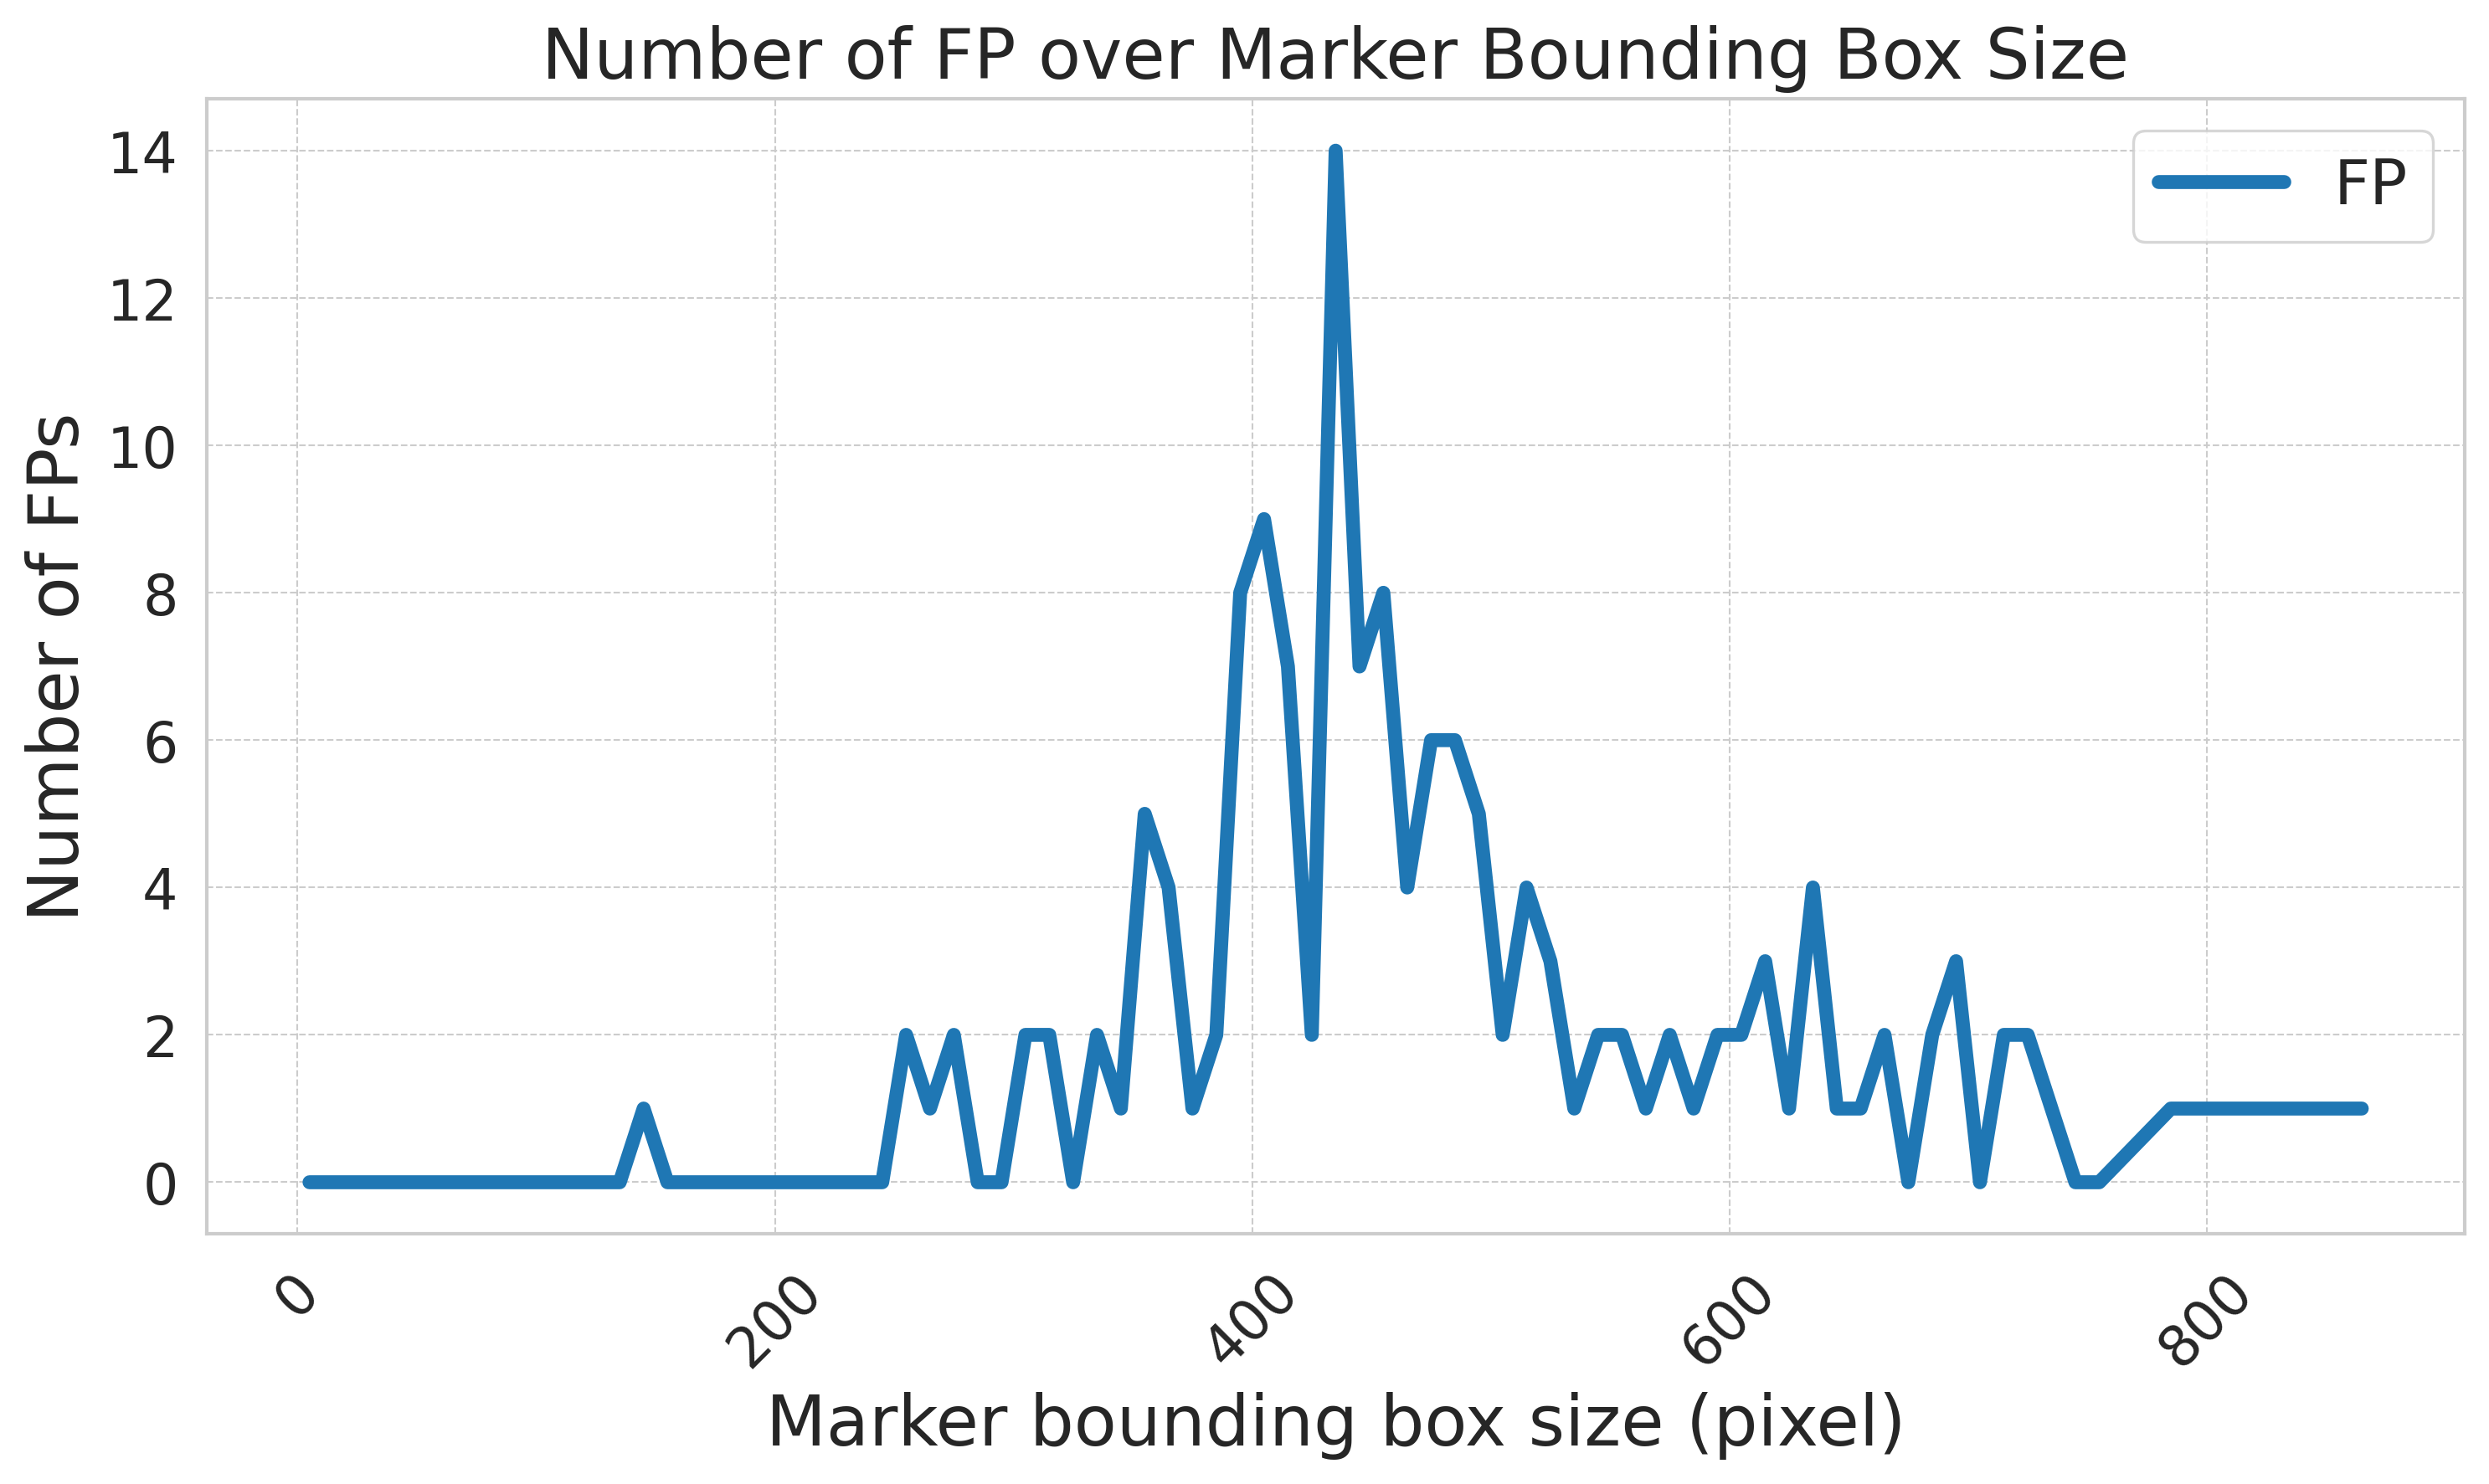

In [115]:
import seaborn as sns

sns.set_context("paper") 
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6), dpi=300)  # Higher DPI for better quality

plt.plot(bin_midpoints, agg_dfm_FP, label='FP', linestyle='-', linewidth=4, markersize=8)


# Label the axes with larger font size
plt.xlabel('Marker bounding box size (pixel)', fontsize=20)
plt.ylabel('Number of FPs', fontsize=20)

# Add a title with a larger font size
plt.title('Number of FP over Marker Bounding Box Size', fontsize=20)

# Customize the legend
plt.legend(fontsize=18, loc='upper right', frameon=True)

# Increase the tick size and rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Remove unnecessary grid lines (optional)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a high-resolution image if needed for publication
plt.tight_layout()  # This ensures everything fits well into the figure
# Show the plot
plt.show()


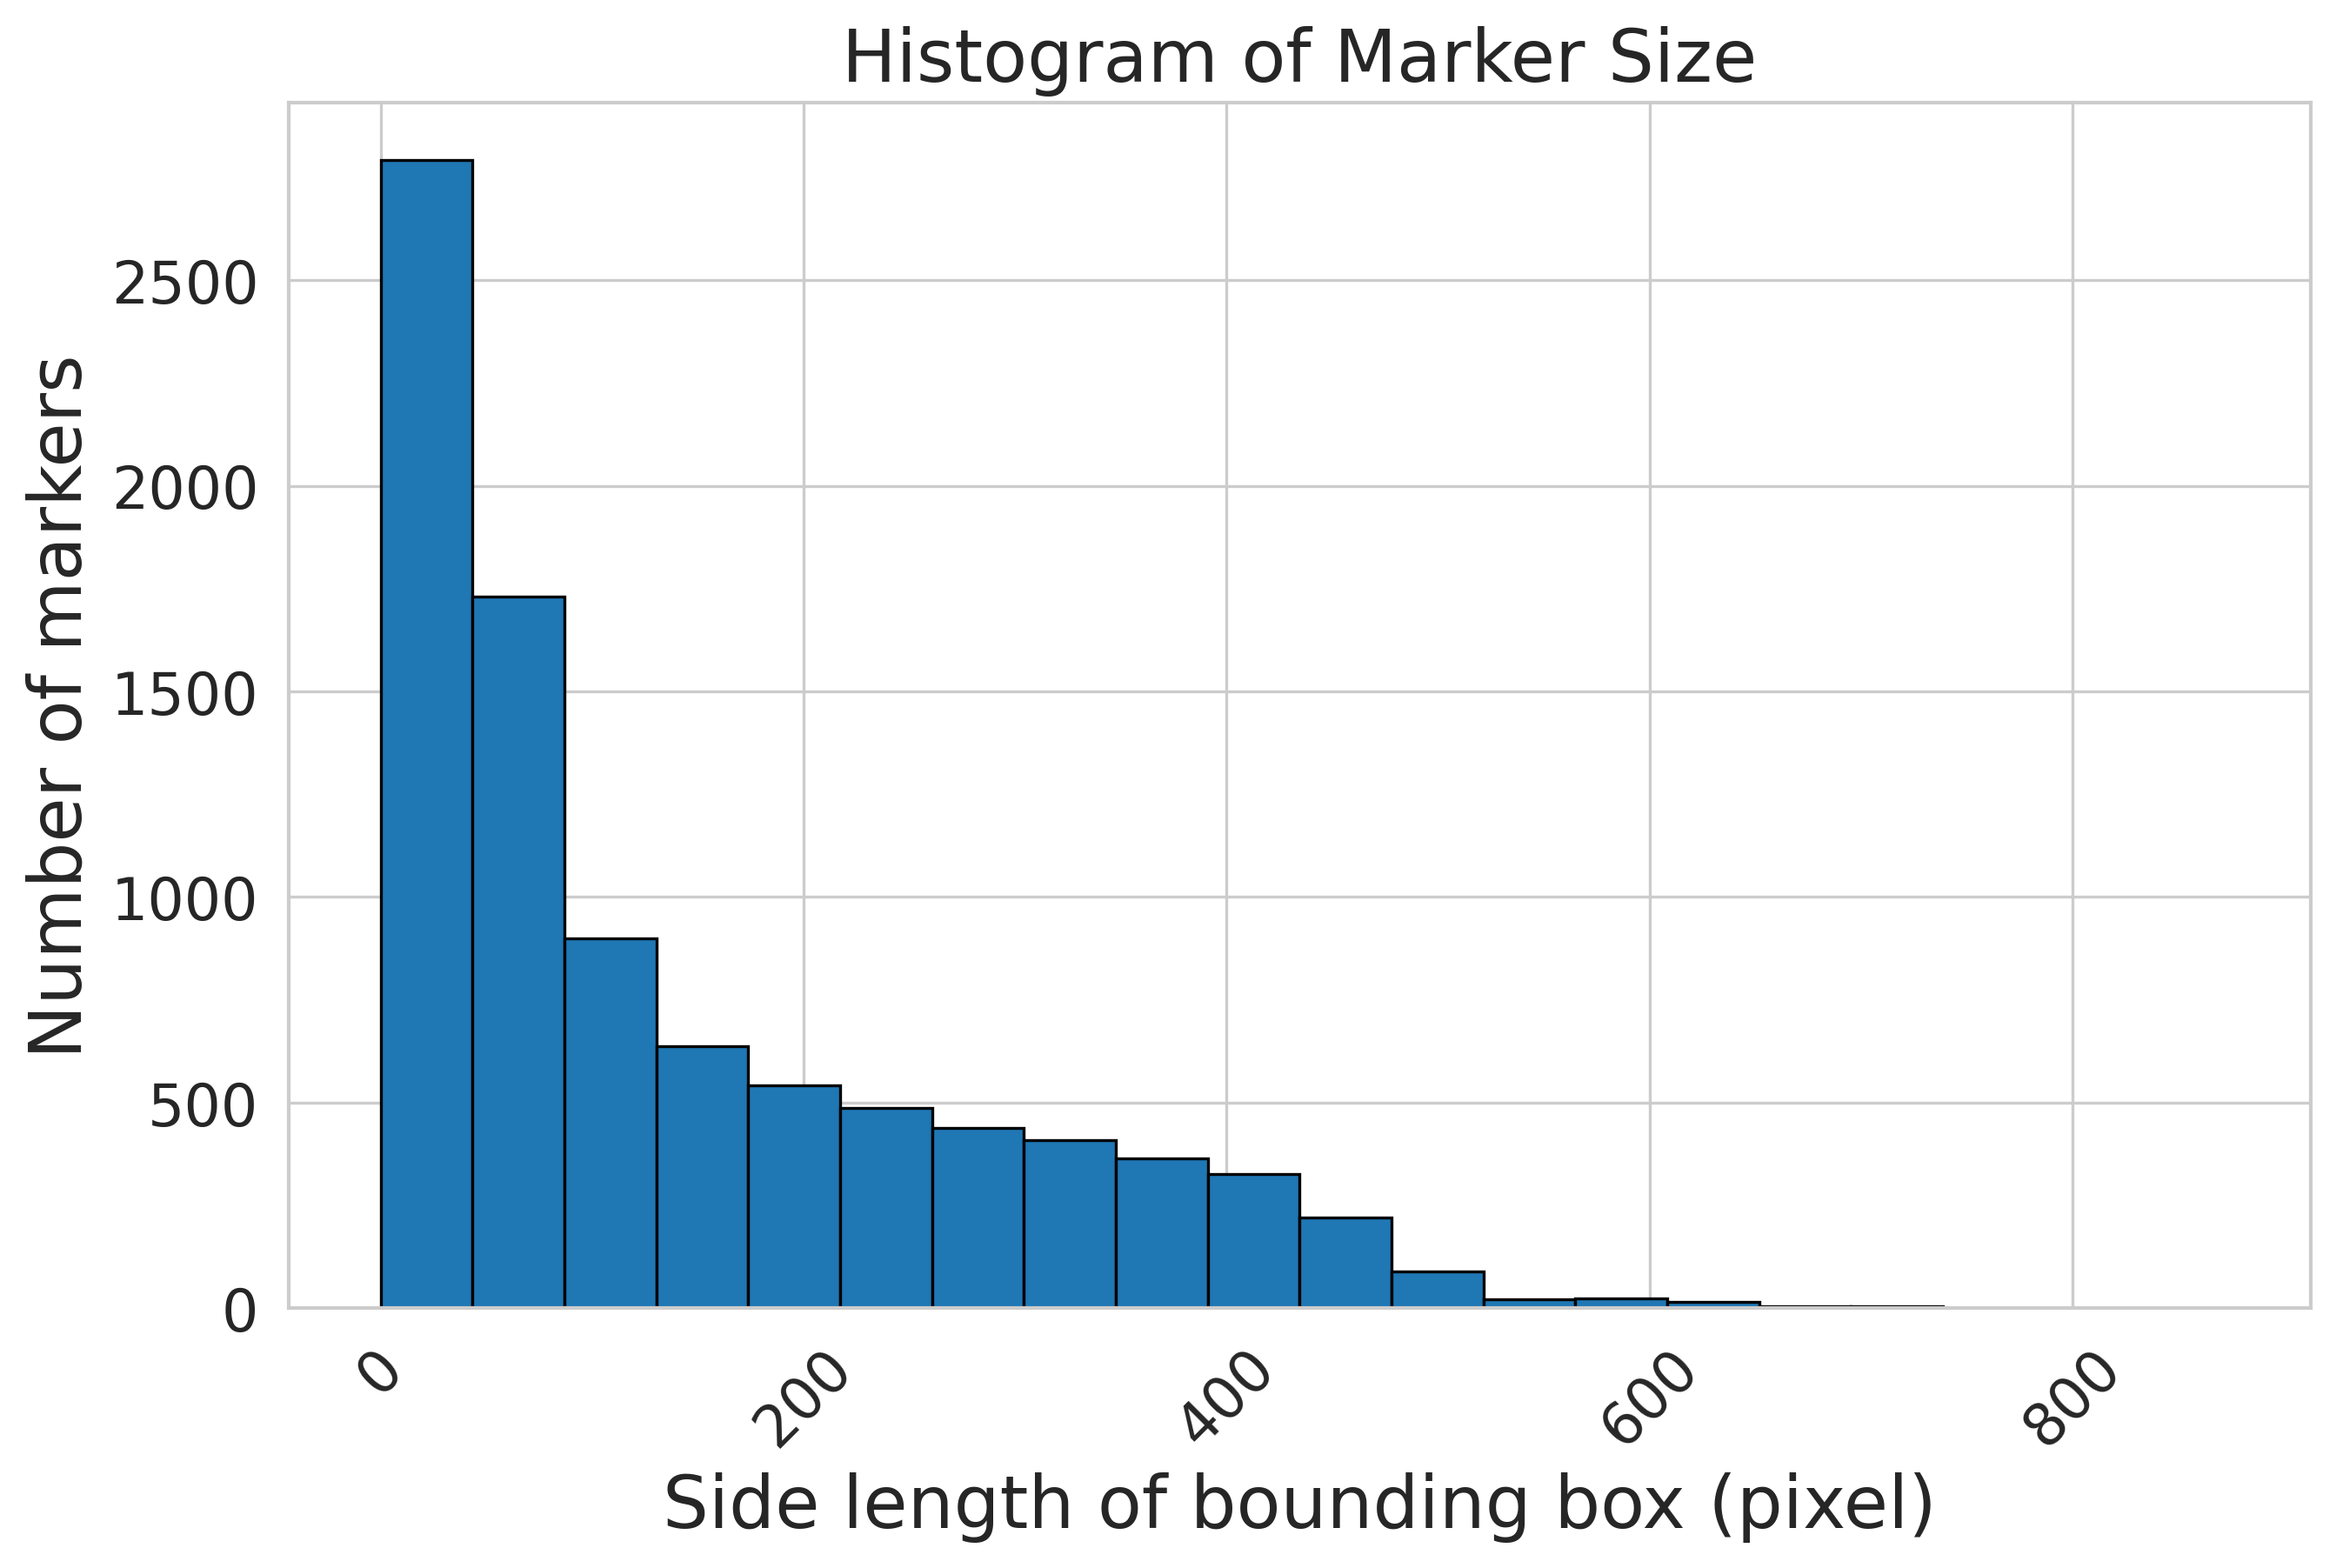

In [78]:
import matplotlib.pyplot as plt

# Filter out zeros from the 'marker_size' column
plt.figure(figsize=(10, 6), dpi=300)  # Higher DPI for better quality
filtered_data = dfm[dfm['FP'] == 0]['marker_size']

# Create the histogram
plt.hist(filtered_data, bins=20, edgecolor='black')
plt.xlabel('Side length of bounding box (pixel)', fontsize=20)
plt.ylabel('Number of markers', fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.title('Histogram of Marker Size', fontsize=20)
plt.show()